In [2]:
import numpy as np
import pandas as pd


In [3]:
from loadAndPreprocess import load_and_preprocess

well_info, _ = load_and_preprocess()

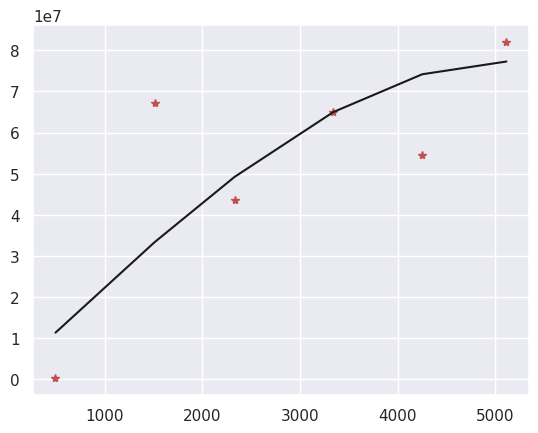

: 

In [45]:
X = well_info['X']
Y = well_info['Y']

# Define grid points for interpolation
grid_x = np.arange(min(X)-500, max(X)+500, 1.0)
grid_y = np.arange(min(Y)-500, max(Y)+500, 1.0)

from pykrige.ok import OrdinaryKriging

values = (well_info['Total Resources'])

ok_res = OrdinaryKriging(
    X,
    Y,
    values,
    variogram_model='spherical',
    enable_plotting=True
)

# Perform the interpolation
z_res, ss_res = ok_res.execute('grid', grid_x, grid_y)

In [38]:
from scipy.spatial import distance_matrix
from scipy.optimize import differential_evolution
from scipy.interpolate import griddata
import pyswarms as ps

def objective_function(x, existing_wells, z_res):
    # Reshape x to (n_particles, n_wells, 2)
    n_particles = x.shape[0]
    n_wells = x.shape[1] // 2
    new_wells = x.reshape(n_particles, n_wells, 2)

    # Initialize return array
    j = np.zeros(n_particles)

    for i in range(n_particles):
        all_wells = np.vstack((existing_wells, new_wells[i]))
        dist_mat = distance_matrix(all_wells, all_wells)
        np.fill_diagonal(dist_mat, np.inf)
        min_distance = np.min(dist_mat)

        total_resources = 0
        # Calculate the total resources on the new well
        for k in range(n_wells):
            # Round coordinates to nearest integer
            ix = int(round(new_wells[i][k][0]))
            iy = int(round(new_wells[i][k][1]))
            # Ensure indices are within the bounds of the array
            ix = max(0, min(ix, z_res.shape[0] - 1))
            iy = max(0, min(iy, z_res.shape[1] - 1))
            total_resources += z_res[ix, iy]
            
        # Objective is to maximize min_distance and total_resources
        j[i] = -min_distance - total_resources

    return j

2024-05-12 09:13:22,364 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 100, 'c2': 100, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=-3.57e+3
2024-05-12 09:13:28,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -3566.9916814661556, best pos: [34838.78019559 50584.30238366 36904.682879   50442.5230152
 34519.16749061 44655.6714321  38563.09467563 49343.15895194
 34819.55310027 45452.62486657]


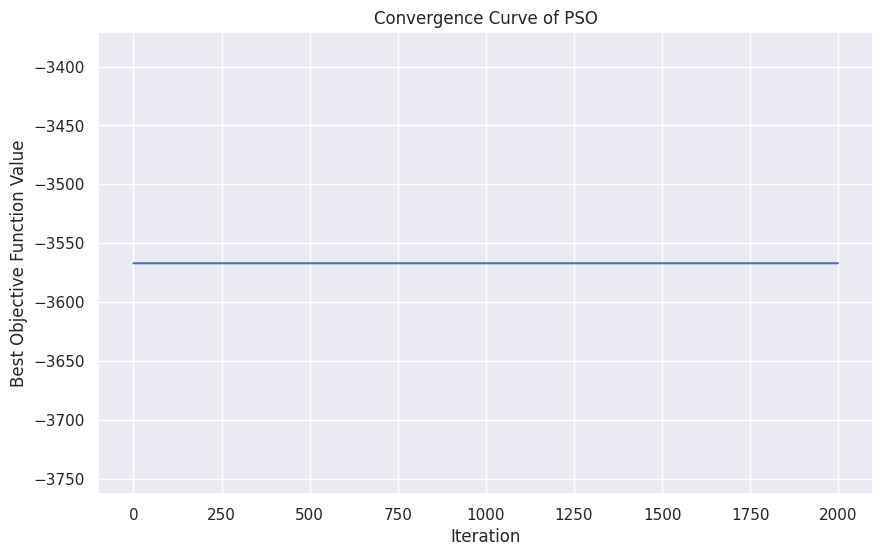

In [44]:
# Extract the existing well coordinates from the DataFrame
existing_wells = well_info[['X', 'Y']].values
num_new_wells = 5
# Define bounds for the problem based on the existing well locations
x_min, y_min = np.min(existing_wells, axis=0)
x_max, y_max = np.max(existing_wells, axis=0)
extension = 0
bounds = (np.array([x_min - extension, y_min - extension] * num_new_wells), 
          np.array([x_max + extension, y_max + extension] * num_new_wells))

# Create an instance of the GlobalBestPSO
options = {'c1': 100, 'c2': 100, 'w': 0.7}
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=num_new_wells * 2, options=options, bounds=bounds)

# Run the optimizer
cost, pos = optimizer.optimize(objective_function, iters=2000, existing_wells=existing_wells, z_res=z_res)

import matplotlib.pyplot as plt

# Plotting the convergence curve
plt.figure(figsize=(10, 6))
plt.plot(optimizer.cost_history)
plt.title('Convergence Curve of PSO')
plt.xlabel('Iteration')
plt.ylabel('Best Objective Function Value')
plt.grid(True)
plt.show()

In [25]:
# Plot the existing and new wells using plotly
import plotly.express as px

existing_wells_df = pd.DataFrame(existing_wells, columns=['X', 'Y'])
existing_wells_df['Type'] = 'Existing'
new_wells_df = pd.DataFrame(pos.reshape(-1, 2), columns=['X', 'Y'])
new_wells_df['Type'] = 'New'

wells_df = pd.concat([existing_wells_df, new_wells_df])

fig = px.scatter(wells_df, x='X', y='Y', color='Type')
fig.update_layout(
    height=600,
    width=700,
)
fig.show()

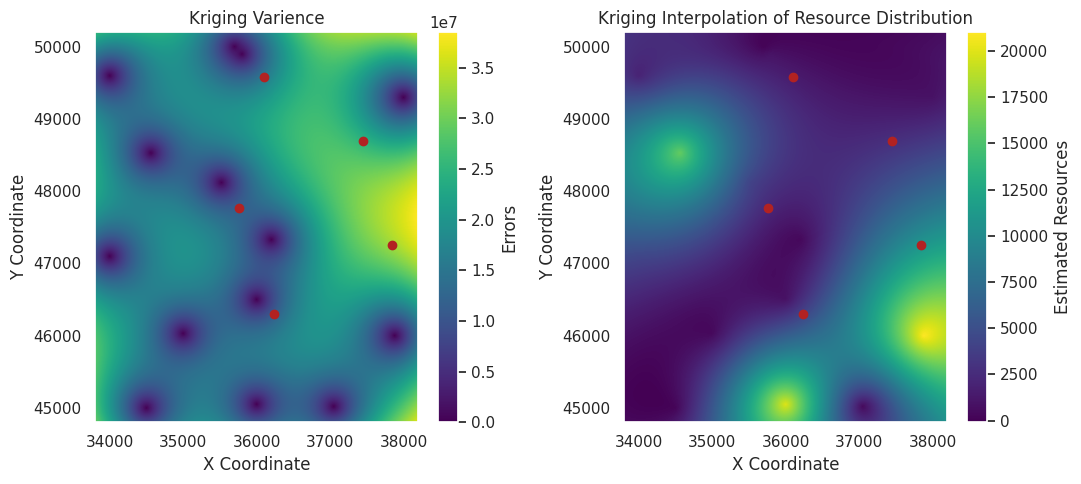

In [26]:
from matplotlib import pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 5))  # 1 row, 2 columns

# Plot the first kriging result on the first subplot
c1 = axs[0].pcolormesh(grid_x, grid_y, ss_res, shading='auto', cmap='viridis')
fig.colorbar(c1, ax=axs[0], label='Errors')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_title('Kriging Varience')
# Add the scatter plot of new wells
axs[0].scatter(pos[::2], pos[1::2], color='firebrick', label='New Wells')


# Plot the second kriging result on the second subplot
c2 = axs[1].pcolormesh(grid_x, grid_y, z_res, shading='auto', cmap='viridis')
fig.colorbar(c2, ax=axs[1], label='Estimated Resources')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].set_title('Kriging Interpolation of Resource Distribution')
# Add the scatter plot of new wells
axs[1].scatter(pos[::2], pos[1::2], color='firebrick', label='New Wells')

# Show the plot
plt.tight_layout()
plt.show()